# Centerloss
Centerloss is a loss that can minimize the intra-class distance
I am proposing the use of centerloss in the 2-layer-network.

Where the Hidden Layer Unit is set to be 3, so that we can visualize it.
In this extra task, I am trying to compare the difference between softmax loss and centerloss

We fixed these params to compare the loss.
input_size,hidden_size,num_classes,num_iters,batch_size

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from cs231n.classifiers.neural_net import TwoLayerNet
from cs231n.classifiers import LinearClassifier

%matplotlib inline
#plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'


# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

Load Data

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


In [39]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

def show_features(X_test,y_test,net):
#     color_map = np.array([[0,0,0],
#                 [255,0,0],
#                 [0,255,0],
#                 [0,0,255],
#                 [255,255,0],
#                 [0,255,255],
#                 [255,0,255],
#                 [128,128,128],
#                 [128,0,128],
#                 [0,128,0]])
    color_map = ["#000000","#FF0000","#00FF00","#0000FF","#FFFF00","#00FFFF","#FF00FF","#808080","#008000","#000080"]
    # get the first layer output ( after reLu)
    W1 = net.params['W1']
    b1 = net.params['b1']
    layer1 = X_val.dot(W1) + b1.reshape(1, -1)
    out = np.maximum(0, layer1)
    # out shpae (N,3)
    fig = plt.figure(figsize=(18, 16), dpi= 80)
#     ax = fig.add_subplot(111, projection='3d')
    ax = fig.add_subplot(111)
    for i in range(10):
        class_i_out = out[y_val==i,:]
#         ax.scatter(class_i_out[:,0],class_i_out[:,1],class_i_out[:,2],c=color_map[i],marker='.')
        ax.scatter(class_i_out[:,0],class_i_out[:,1],c=color_map[i],marker='.')
        
    plt.show()
    return

Using Softmaxloss

In [40]:
input_size = 32 * 32 * 3
hidden_size = 2
num_classes = 10
num_iters=1000
batch_size=400
learning_rate = 1e-3
reg = 0.3
net = TwoLayerNet(input_size, hidden_size, num_classes)
# Train the network
start_time = time.time()
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=num_iters, batch_size=batch_size,
            learning_rate=learning_rate, learning_rate_decay=0.95,
            reg=reg, verbose=True)
print('Elasped Time :{:.3f}'.format(time.time()-start_time))

y_test_pred = net.predict(X_test)
acc = np.mean(y_test == y_test_pred)
print("accuracy =",acc)

iteration 0 / 1000: loss 2.302600
iteration 100 / 1000: loss 2.091076
iteration 200 / 1000: loss 2.019651
iteration 300 / 1000: loss 2.058440
iteration 400 / 1000: loss 2.022033
iteration 500 / 1000: loss 2.056509
iteration 600 / 1000: loss 2.024153
iteration 700 / 1000: loss 1.968495
iteration 800 / 1000: loss 2.103925
iteration 900 / 1000: loss 2.071126
Elasped Time :16.445
accuracy = 0.202


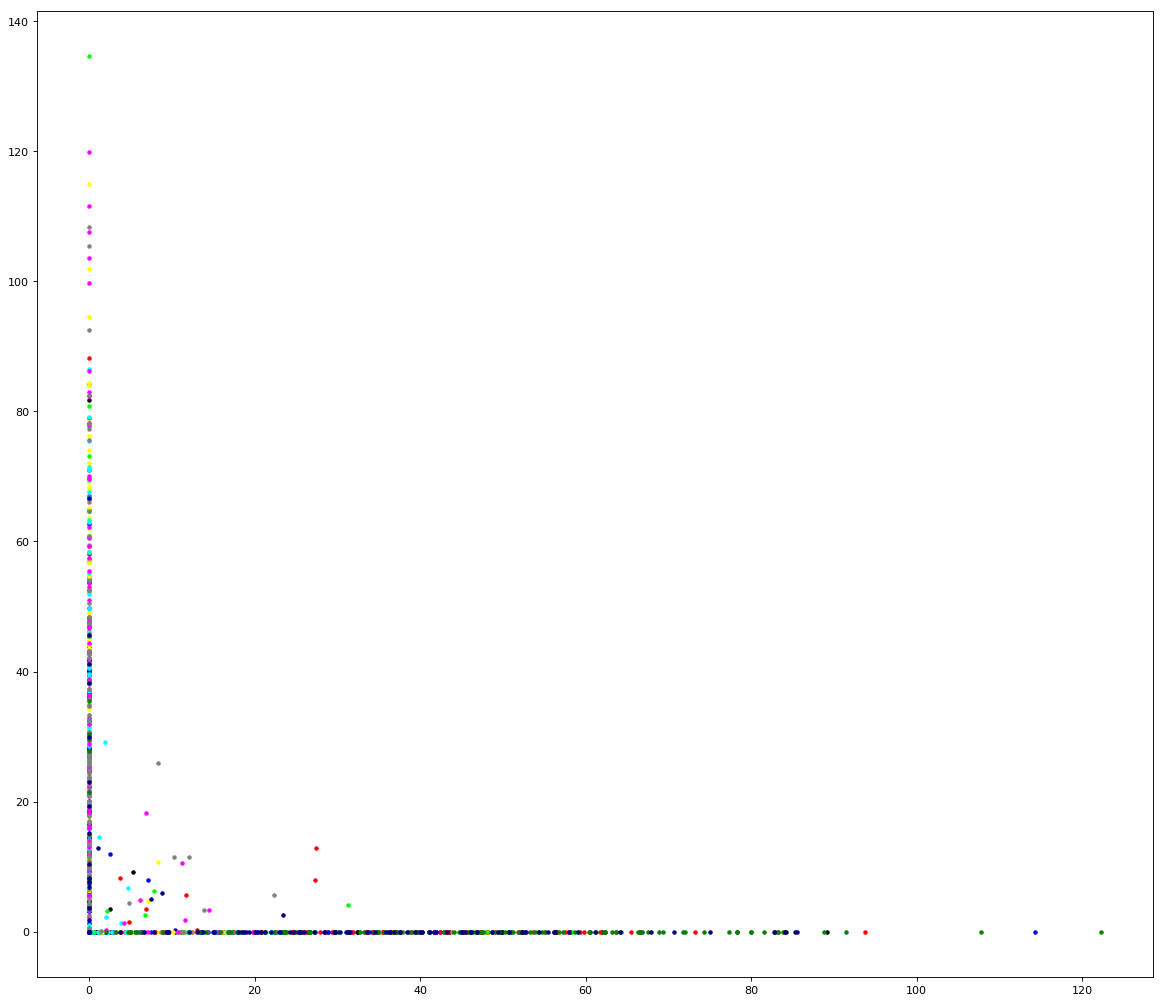

In [42]:
# show features
show_features(X_test,y_test,net)

Centerloss

In [36]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from past.builtins import xrange


class Center_loss_net(object):

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
  
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0, ratio=0.5):

        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape
        C  = W2.shape[1]
        H = W1.shape[1]
        scores = None
        # X: (N, D)
        # W1: (D, H)
        # b1: (H,)
        # W2: (H, C)
        # b2: (C,)
        layer1 = X.dot(W1) + b1.reshape(1, -1)
        reLu = np.maximum(0, layer1)
        layer2 = reLu.dot(W2) + b2
        # layer1: (N,H), relu: (N,H), layer2: (N,C)
        scores = layer2

        if y is None:
            return scores

        # Compute the loss
        loss = None
        # score: (N,C), softmax: (N,C)
        exp_scores = np.exp(scores)
        softmax = exp_scores[np.arange(N), y] / np.sum(exp_scores, axis=1)
        loss = np.average(-np.log(softmax)) + reg * (np.sum(W1 * W1) + np.sum(W2 * W2))
        
        ### Center loss here
        # cal center, shape = (C,H)
        center_loss = 0
        centers = np.zeros((C,H))
        diff = np.zeros((N,H))
        Centers = np.zeros((N,H))
        for i in range(C):
            reLu_i = reLu[y==i,:]
            centers[i] = np.mean(reLu_i,axis = 0)
        for i in range(N):
            diff[i] = reLu[i]-centers[y[i]]
#             print(diff[i])
#             center_loss +=(np.sum(diff[i])) # L1 distance
        center_loss = np.sum(diff)/(N)
#         print(center_loss)
        loss  += ratio * center_loss
        # Backward pass: compute gradients
        grads = {}
        #############################################################################
        # TODO: Compute the backward pass, computing the derivatives of the weights #
        # and biases. Store the results in the grads dictionary. For example,       #
        # grads['W1'] should store the gradient on W1, and be a matrix of same size #
        #############################################################################
        # D_softmax wrt  S, shape = (N,C)
        
        D_center = np.ones_like(diff)
        D_center[np.where(reLu <= 0)] = 0
        DCDW = np.zeros((C,D))
        for i in range(C):
            a = X
            a[np.where(reLu <= 0)] = 0
            a=a[y==i]
            DCDW[i] =  1/N * np.sum(a,axis=0)
#             bb = np.ones((N,))
#             bb[np.where(reLu <= 0)] = 0
            
        DXDW_ = np.zeros_like(X)
        for i in range(N):
            DXDW_[i] = DCDW[y[i]]
        D_center_W1 = np.dot(X.T-DXDW_.T,D_center)
        D_center_W1 = D_center_W1*ratio / N 
        D_center_b1 = np.dot(np.ones((N,)),D_center)
        D_center_b1 = D_center_b1*ratio/N
        D_softmax = exp_scores / np.sum(exp_scores, axis=1).reshape(-1, 1)
        D_softmax[np.arange(N), y] -= 1

        D_W2 = np.dot(reLu.T, D_softmax)
        grads['W2'] = D_W2 / N + 2 * reg * W2
        D_b2 = np.dot(np.ones(N).T, D_softmax)
        grads['b2'] = D_b2 / N
        # D_ReLu wrt ReLu, shape = (N,H)
        D_reLu = np.dot(D_softmax, W2.T)
        D_reLu[np.where(reLu <= 0)] = 0
        D_W1 = X.T.dot(D_reLu)
        grads['W1'] = D_W1 / N + 2 * reg * W1 +  D_center_W1
        D_b1 = np.dot(np.ones(N), D_reLu)
        grads['b1'] = D_b1 / N + D_center_b1
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        return loss, grads

    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95,
              reg=5e-6, num_iters=100,
              batch_size=200, verbose=False):
        """
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in xrange(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO: Create a random minibatch of training data and labels, storing  #
            # them in X_batch and y_batch respectively.                             #
            #########################################################################
            indices = np.random.choice(X.shape[0], batch_size, replace=True)
            X_batch = X[indices, :]
            y_batch = y[indices]
            #########################################################################
            #                             END OF YOUR CODE                          #
            #########################################################################

            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            #########################################################################
            # TODO: Use the gradients in the grads dictionary to update the         #
            # parameters of the network (stored in the dictionary self.params)      #
            # using stochastic gradient descent. You'll need to use the gradients   #
            # stored in the grads dictionary defined above.                         #
            #########################################################################
            for k in self.params:
                self.params[k] += - learning_rate * grads[k]
            #########################################################################
            #                             END OF YOUR CODE                          #
            #########################################################################

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
            'loss_history': loss_history,
            'train_acc_history': train_acc_history,
            'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
          the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
          to have class c, where 0 <= c < C.
        """
        y_pred = None

        ###########################################################################
        # TODO: Implement this function; it should be VERY simple!                #
        ###########################################################################
        scores = self.loss(X)
        y_pred = np.argmax(scores,axis=1)
        ###########################################################################
        #                              END OF YOUR CODE                           #
        ###########################################################################

        return y_pred


In [41]:
input_size = 32 * 32 * 3
hidden_size = 2
num_classes = 10
num_iters=1000
batch_size=200
learning_rate = 1e-5
reg = 3000
clnet = Center_loss_net(input_size, hidden_size, num_classes)
# Train the network
start_time = time.time()
stats = clnet.train(X_train, y_train, X_val, y_val,
            num_iters=num_iters, batch_size=batch_size,
            learning_rate=learning_rate, learning_rate_decay=0.95,
            reg=reg, verbose=True)
print('Elasped Time :{:.3f}'.format(time.time()-start_time))

y_test_pred = net.predict(X_test)
acc = np.mean(y_test == y_test_pred)
print("accuracy =",acc)

iteration 0 / 1000: loss 2.490110
iteration 100 / 1000: loss 2.345638
iteration 200 / 1000: loss 2.340323
iteration 300 / 1000: loss 2.319297
iteration 400 / 1000: loss 2.342373
iteration 500 / 1000: loss 2.321940
iteration 600 / 1000: loss 2.331955
iteration 700 / 1000: loss 2.318229
iteration 800 / 1000: loss 2.324030
iteration 900 / 1000: loss 2.321780
Elasped Time :22.677
accuracy = 0.202


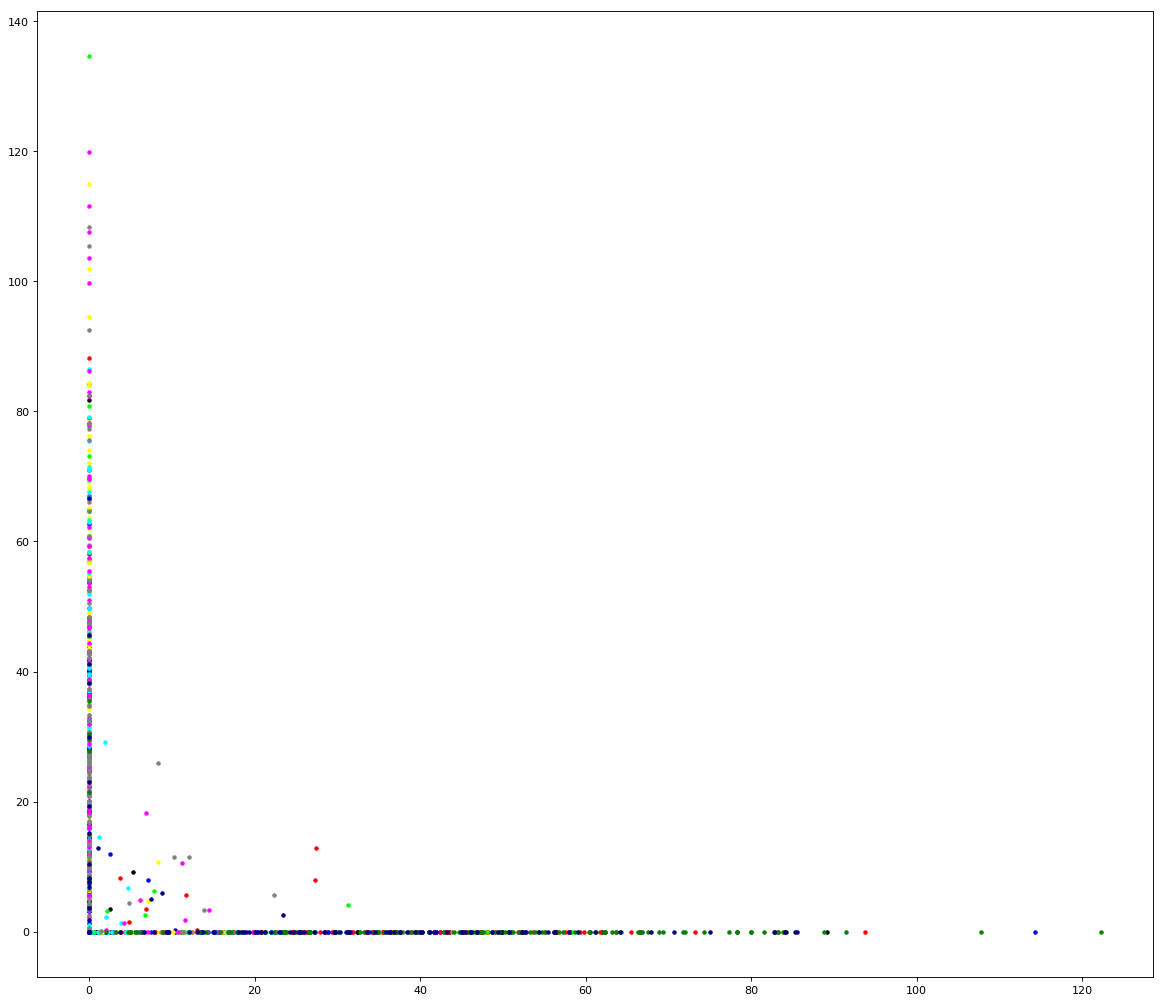

In [43]:
# show features
show_features(X_test,y_test,net)